# Filtering GPS track

<br/>
<div class="alert alert-block alert-warning" style="padding:1em">
<b>Filtering:</b> this operation altering observation values preserving timestamps and without deleting or creating new observations. Methods are usually "local" methods and working with a neighborhood (e.g. kernel).</div>

In **tracklib**, filtering approaches available are:

* des filtres séquentiels (ou filtres à noyaux), qui travaillent directement dans le domaine spatial ou temporel et avec un noyau local

* des filtres dynamiques (qui nécessitent des informations sur la dynamique du mobile) : Kalman et Markov


## Let's start by defining our environment

This task is only useful for the online notebook

In [1]:
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# Import de tracklib

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tracklib as trk

In [2]:
# Import de la librairie tracklib
import tracklib as tkl

# And others
import matplotlib.pyplot as plt

## Filtrage par noyau fenetre glissante de taille 5

In [3]:
# Chargement des données
csvpath = '../../../data/trace0.gps'
        
tkl.ObsTime.setPrintFormat("2D/2M/4Y 2h:2m:2s.3z")
param = tkl.TrackFormat({
    'ext': 'CSV', 
    'id_E': 2, 
    'id_N': 3, 
    'id_U': -1, 
    'id_T': 1,
    'header': 0,
    'separator': ','
})
track = tkl.TrackReader.readFromFile(csvpath, param)%10

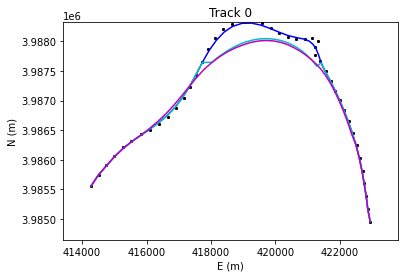

In [4]:
track.plot('kx')
plt.ylim([3986100, 3986800])

# Filtrage par noyau fenetre glissante de taille 5
track1 = tkl.filter_seq(track, kernel=5, dim=tkl.FILTER_XY)
track1.plot('b-')

# Filtrage par noyau gaussien
track2 = tkl.filter_seq(track, kernel=tkl.GaussianKernel(5), dim=tkl.FILTER_XY)
track2.plot('c-')

# Filtrage par noyau triangulaire
track3 = tkl.filter_seq(track, kernel=tkl.TriangularKernel(5), dim=tkl.FILTER_XY)
track3.plot('m-')

plt.show()

## Application à la détection des lacets

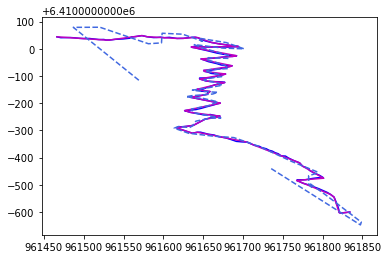

In [5]:
tkl.ObsTime.setReadFormat("4Y-2M-2D 2h:2m:2s")
trackpath = '../../../cotation/balcon/data/cedera_l93.csv'
param = tkl.TrackFormat({
    'ext': 'CSV', 
    'id_E': 0, 
    'id_N': 1, 
    'id_U': 2, 
    'id_T': -1, 
    'separator': ';', 
    'header': 1
})
track = tkl.TrackReader.readFromFile(trackpath, param)

# 1010
trace2 = track.extract(750, 950)
trace = tkl.simplify(trace2, 5, tkl.MODE_SIMPLIFY_DOUGLAS_PEUCKER)
track_init = trace.copy()

# Fourier
track2 = tkl.filter_freq(trace, 0.5, 
                         mode=tkl.FILTER_SPATIAL, dim=tkl.FILTER_XY,
                         type=tkl.FILTER_LOW_PASS)

plt.plot(trace2.getX(), trace2.getY(), 'b-')
plt.plot(trace.getX(), trace.getY(), 'm-')
plt.plot(track2.getX(), track2.getY(), color="royalblue",  linestyle='--',)

100% (63 of 63) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


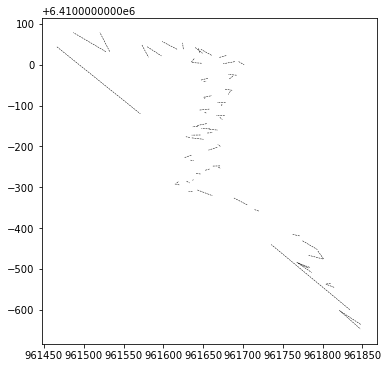

In [6]:
plt.figure(figsize=(6, 6))
profile = tkl.match(trace, track2, mode=tkl.MODE_MATCHING_DTW)
tkl.plotMatching(profile, track2, append=True)

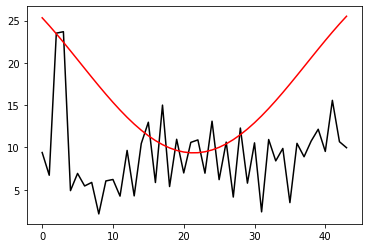

In [7]:
plt.plot(profile.getAnalyticalFeature("diff")[10:-10], 'k-')
profile_filtered = tkl.filter_freq(profile, 1.0/20, dim=["diff"], mode=tkl.FILTER_SPATIAL)
tab = profile_filtered.getAnalyticalFeature("diff")[10:-10]
plt.plot(tab, 'r-')

nb virages =  1


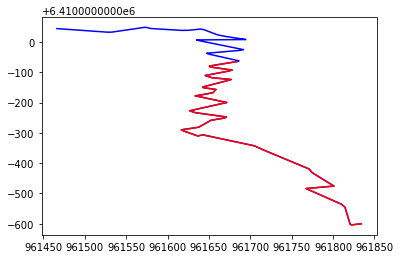

In [8]:
seuil = 5.0
VIRAGES = []
xmin = -1
xmax = -1
for i in range(len(tab)):
    val = tab[i]
    if val > seuil:
        # print (xmin)
        # Est-ce que c'est la première valeur ?
        if xmin < 0:
            xmin = i
    else:
        # Est-ce qu'on était dans un virage ?
        if xmin > 0:
            xmax = i
                
    if xmin > 0 and xmax > 0:
        VIRAGES.append([xmin, xmax])
        xmin = -1
        xmax = -1

if xmin >= 0:
    xmax = len(tab)-1
    VIRAGES.append([xmin, xmax])

print ('nb virages = ', len(VIRAGES))


plt.plot(track_init.getX(), track_init.getY(), 'b-')

for cpt, lacet in enumerate(VIRAGES):
    virages1 = trace.extract(lacet[0], lacet[1])
    plt.plot(virages1.getX(), virages1.getY(), '-', color='red')

### Overview

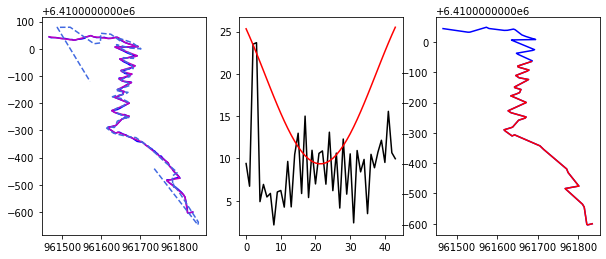

In [9]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax1.plot(trace2.getX(), trace2.getY(), 'b-')
ax1.plot(trace.getX(), trace.getY(), 'm-')
ax1.plot(track2.getX(), track2.getY(), color="royalblue",  linestyle='--')

ax2 = plt.subplot2grid((1, 3), (0, 1))
ax2.plot(profile.getAnalyticalFeature("diff")[10:-10], 'k-')
ax2.plot(tab, 'r-')

ax3 = plt.subplot2grid((1, 3), (0, 2))
ax3.plot(track_init.getX(), track_init.getY(), 'b-')
for cpt, lacet in enumerate(VIRAGES):
    virages = trace.extract(lacet[0], lacet[1])
    ax3.plot(virages.getX(), virages1.getY(), '-', color='red')